In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

In [2]:
f = np.load('/local/data/<user>/disentanglement_multitask/mpi3d_real.npz')
print(f)


In [3]:
print(list(f.keys()))

['images']


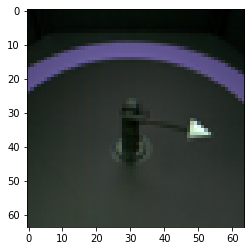

In [4]:
images = f['images'].reshape([-1,64,64,3])
plt.imshow(images[0])
# images.reshape([6,6,2,3,3,40,40,64,64,3])

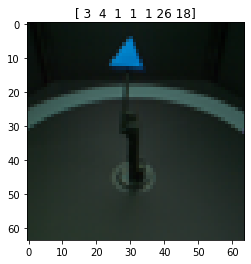

In [5]:
images.shape


def process_index(idx):
    dimensions = [6,6,2,3,3,40,40]
    label = []

    for d in reversed(dimensions):
        label += [idx % d]
        idx = idx // d
    return list(reversed(label))

labels = process_index(np.arange(len(images)))
labels = np.array(labels).transpose(1, 0)

idx = 655458
plt.imshow(images[idx])
plt.title(str(labels[idx]))
plt.show()


dataset_x = torch.tensor(labels).cuda().float()

In [39]:
torch.manual_seed(658)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

networks = []
multitask_targets = []
for network in range(50):
    network = nn.Sequential(
        nn.Linear(7, 300),
        nn.Tanh(),
        nn.Linear(300, 300),
        nn.Tanh(),
        nn.Linear(300, 300),
        nn.Tanh(),
        nn.Linear(300, 300),
        nn.Tanh(),
        nn.Linear(300, 1),
    )
    
    for module in network.children():
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight.data, 0, 1.)
            
    network = network.cuda()
    targets = network(dataset_x)
    targets = targets.detach().cpu().numpy()
    multitask_targets += [targets]

multitask_targets = np.concatenate(multitask_targets, 1)

In [45]:
mpi3d = {'images': images, 'labels': labels, 'multitask_targets': multitask_targets}
np.savez_compressed("mpi3d_multitask.npz", **mpi3d)

In [46]:
A = np.load('mpi3d_multitask.npz')
print(A['multitask_targets'][0])

[-11.780248    -0.21679541  -0.39157826  51.10386     11.741002
 -20.40133    -10.99998     35.743584   -21.485134    -0.10833603
  -6.3265314    5.3337183    0.45183036 -44.748135     1.0263846
 -16.234142    10.764619   -17.793833   -11.27251     -7.739171
  16.869694     3.9488254   -5.576894    -8.402218     0.6171662
  27.24728      1.9098554  -14.695993     0.27298242  -6.4692616
   5.4376836   26.029087    -2.8916068   24.56573      0.5793803
  26.435556    12.672287    18.62973      9.656433    13.737272
 -15.70365     -4.396952     6.569562    -6.1971693  -21.064194
 -12.520681    -9.120901    -3.5052545  -31.046425     8.920781  ]


In [49]:
images = A['images']
labels = A['labels']


1036800 1036800


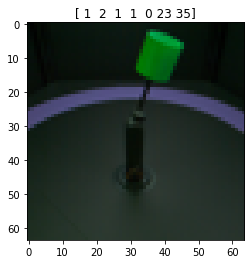

In [61]:
idx = 250555
print(len(images), len(labels))
plt.imshow(images[idx])
plt.title(labels[idx])
plt.show()

# Custom Splits

In [6]:
num_tasks=50
num_true = 7


#[1,1,0,0,0,0],
#[1,1,1,0,0,0],
#[1,1,1,1,0,0],etc
grow_splits = []
for i in range(num_tasks):
    temp = np.zeros(num_true)
    temp[:((i%(num_true-1))+2)] = 1.0
    grow_splits.append(temp)


#[1,1,0,0,0,0],
#[0,0,1,1,0,0],
#[0,0,0,0,1,1],etc.
independent_splits_v1 = []
div_size=2
for i in range(num_tasks):
    k = num_true//div_size
    temp = np.zeros(num_true)
    j = i%k
    if num_true-div_size*(j+1)<div_size:
        end = num_true
    else:
        end = div_size*(j+1)
    temp[div_size*j:end] = 1.0
    independent_splits_v1.append(temp)
    
    
independent_splits_v2 = []
div_size=3
for i in range(num_tasks):
    k = num_true//div_size
    temp = np.zeros(num_true)
    j = i%k
    if num_true-div_size*(j+1)<div_size:
        end = num_true
    else:
        end = div_size*(j+1)
    temp[div_size*j:end] = 1.0
    independent_splits_v2.append(temp)    

#random
#[1,0,1,1,0,0]
#[0,0,1,0,1,1], etc. 
rs = np.random.RandomState(11)
random_splits = []
for i in range(num_tasks):
    temp = np.zeros(num_true)
    temp[rs.rand(len(temp))>0.5]=1.0
    if(sum(temp)==0):
        i = rs.randint(num_true)
        temp[i]=1.0
    random_splits.append(temp)
    


torch.manual_seed(658)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class Masked(nn.Module):
    def __init__(self, split, input_shape):
        super(Masked, self).__init__()
        self.split = split
        self.input_shape = input_shape
        self.mask = torch.zeros(self.input_shape, dtype=torch.float32).cuda()
        self.mask[self.split] = 1
    
    def forward(self, input):
        return self.mask*input
        
    
SPLITS={
    "grow":grow_splits,
    "independent_v1":independent_splits_v1,
    "independent_v2":independent_splits_v2,
    "random":random_splits
}
    
    
    
def save_splitted_dataset(split_type):
    networks = []
    multitask_targets = []
    split_array = SPLITS[split_type]
    for network in range(50):
        network = nn.Sequential(
            Masked(split_array[network], 7),
            nn.Linear(7, 300),
            nn.Tanh(),
            nn.Linear(300, 300),
            nn.Tanh(),
            nn.Linear(300, 300),
            nn.Tanh(),
            nn.Linear(300, 300),
            nn.Tanh(),
            nn.Linear(300, 1),
        )

        for module in network.children():
            if isinstance(module, nn.Linear):
                torch.nn.init.normal_(module.weight.data, 0, 1.)

        network = network.cuda()
    
        
        targets = network(dataset_x)
        targets = targets.detach().cpu().numpy()
        multitask_targets += [targets]

    multitask_targets = np.concatenate(multitask_targets, 1)

    mpi3d = {'images': images, 'labels': labels, 'multitask_targets': multitask_targets}
    np.savez_compressed("mpi3d_multitask_{}_splits.npz".format(split_type), **mpi3d)

In [7]:
independent_splits_v1

[array([1., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 1., 1.]),
 array([1., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 1., 1.]),
 array([1., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 1., 1.]),
 array([1., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 1., 1.]),
 array([1., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 1., 1.]),
 array([1., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 1., 1.]),
 array([1., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 1., 1.]),
 array([1., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 1., 1.]),
 array([1., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 1., 0., 0., 0.]),
 array([0., 

In [8]:
independent_splits_v2

[array([1., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 1., 1., 1.]),
 array([1., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 1., 1., 1.]),
 array([1., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 1., 1., 1.]),
 array([1., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 1., 1., 1.]),
 array([1., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 1., 1., 1.]),
 array([1., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 1., 1., 1.]),
 array([1., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 1., 1., 1.]),
 array([1., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 1., 1., 1.]),
 array([1., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 1., 1., 1.]),
 array([1., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 1., 1., 1.]),
 array([1., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 1., 1., 1.]),
 array([1., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 1., 1., 1.]),
 array([1., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 1., 1., 1.]),
 array([1., 

In [9]:
print("grow")
save_splitted_dataset("grow")
print("independent_v1")
save_splitted_dataset("independent_v1")
print("independent_v2")
save_splitted_dataset("independent_v2")
print("random")
save_splitted_dataset("random")

grow
independent_v1
independent_v2
random
